In [1]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import json

In [2]:
e2e_folder = "../../../../test/e2e/"

In [3]:
test_states = 8
iterations = 2

timeout = 300

json_stats = dict()

for n_states in range(1, test_states + 1):
    print(f"---- Starting test of n_states {n_states} ----")

    json_stats[n_states] = []

    with open(f"{e2e_folder}networks/simple.toml", "r") as src:
        with open(f"{e2e_folder}/networks/simple_modified.toml", "w") as dst:
            for l in src:
                if l.startswith("n_states"):
                    dst.write(f"n_states = {n_states}\n")
                else:
                    dst.write(l)
    
    with open("benchmark.txt", "w") as f:
        f.write("")
    
    success = 0
    for i in range(iterations):
        try:
            subprocess.run([f"{e2e_folder}/build/runner", "-f", f"{e2e_folder}/networks/simple_modified.toml", "benchmark"], timeout=timeout)
            success += 1
        except:
            print(f"Timing out after {timeout}s")
            if success == 0 and i == iterations - 1:
                i -= 1

    with open("benchmark.txt", "r") as f:
        for l in f:
            json_stats[n_states].append(l)

    print("Updated json_stats")
    print(json_stats)

with open("benchmark_total.txt", "w") as f:
    f.write(json.dumps(json_stats))

---- Starting test of n_states 1 ----
Testnet load rate: 50ms
I[2025-08-10|21:06:14.580] Removing Docker containers and networks      
I[2025-08-10|21:06:17.169] setup                                        msg="Generating testnet files in `../../../../test/e2e//networks/simple_modified`"
I[2025-08-10|21:06:17.183] Starting initial network nodes...            
I[2025-08-10|21:06:17.184] load                                         msg="Starting transaction load (16 workers)..."
E[2025-08-10|21:06:17.192] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5701/v1\": dial tcp 127.0.0.1:5701: connect: connection refused"
E[2025-08-10|21:06:17.192] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5707/v1\": dial tcp 127.0.0.1:5707: connect: connection refused"
D[2025-08-10|21:06:17.192] load                                         success=0 failed=2 success/total=0.00 tx/s=0.0
E[2025-08-10|21:06:17.237] failed 

## with open("benchmark_total.txt", "r") as f:
    json_stats = json.load(f)
print("Last json_stats")
print(json_stats)

In [5]:
mean_times = dict()
max_times = dict()
min_times = dict()

for n_states, stats in json_stats.items():
    mean_times[n_states] = 0
    max_times[n_states] = -1000
    min_times[n_states] = 1000

    for json_stat in stats:
        stat = json.loads(json_stat)
        mean_times[n_states] += stat["mean"]
        max_times[n_states] = max(max_times[n_states], stat["max"])
        min_times[n_states] = min(min_times[n_states], stat["min"])
    mean_times[n_states] /= len(stats)

print(f"Stats for all {len(mean_times)} tests")
for n_states in mean_times:
    print(f"Stats for {n_states}: Mean {mean_times[n_states]} max {max_times[n_states]} min {min_times[n_states]}")

Stats for all 8 tests
Stats for 1: Mean 1.4125948035 max 1.7244248340000001 min 1.291493875
Stats for 2: Mean 0.7304410975 max 1.53031725 min 0.000168417
Stats for 3: Mean 0.5324099345 max 1.712033084 min 0.000103958
Stats for 4: Mean 0.4239193905 max 1.863780209 min 0.000788167
Stats for 5: Mean 0.407337517 max 2.809843543 min 5.825e-05
Stats for 6: Mean 0.3822816615 max 2.959228543 min 1.8041e-05
Stats for 7: Mean 0.370389065 max 2.689783418 min 0.000186458
Stats for 8: Mean 0.35269997249999996 max 2.869766335 min 6.4333e-05


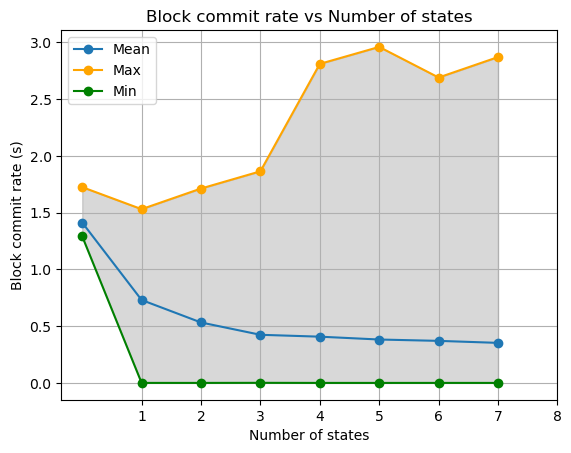

In [6]:
# plotting inv_throughput

plt.plot(mean_times.keys(), mean_times.values(), marker='o')
plt.plot(max_times.keys(), max_times.values(), marker='o', color='orange')
plt.plot(min_times.keys(), min_times.values(), marker='o', color='green')
plt.fill_between(mean_times.keys(), min_times.values(), max_times.values(), color='gray', alpha=0.3)
plt.legend(["Mean", "Max", "Min"])

plt.xlabel("Number of states")
plt.ylabel("Block commit rate (s)")
plt.title("Block commit rate vs Number of states")
plt.xticks(range(1, len(mean_times) + 1), range(1, len(mean_times) + 1))
plt.grid()
plt.savefig("block_commit_rate.png")
plt.show()

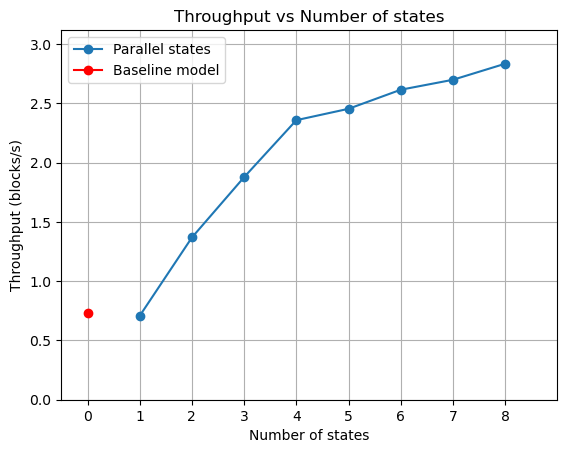

In [7]:
throughput = dict()
for n_states in mean_times:
    throughput[int(n_states)] = 1 / mean_times[n_states]
    
plt.plot(throughput.keys(), throughput.values(), marker='o')
# plot point (0, 1.371208389)
plt.plot(0, 1 / 1.371208389, marker='o', color='red')

plt.legend(["Parallel states", "Baseline model"])

plt.xlabel("Number of states")
plt.ylabel("Throughput (blocks/s)")
plt.title("Throughput vs Number of states")
plt.xticks(range(0, len(throughput) + 1), range(0, len(throughput) + 1))
plt.xlim(-0.5, len(throughput) + 1)
plt.ylim(0, max(throughput.values()) * 1.1)
plt.grid()
plt.savefig("throughput_vs_nstates.png")
plt.show()